In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from experiment_train import *
from experiment_datasets import *

Using TensorFlow backend.


Initialized TensorFlow


In [2]:
class TrainExperimentShowResilience(TrainExperiment):
    def __init__(self, x_train, y_train, x_test, y_test, N, p_inference = None, p_train = None, KLips = 1, epochs = 20, activation = 'sigmoid', reg_type = None, reg_coeff = 0.01, do_print = False, name = 'exp', seed = 0, batch_size = 10000, exp_skip = 10):
        """ Get a trained with MSE loss network with configuration (N, P, activation) and reg_type(reg_coeff) with name. The last layer is linear
                N: array with shapes [hidden1, hidden2, ..., hiddenLast]. Input and output shapes are determined automatically
                p_inference: array with [p_input, p_h1, ..., p_hlast, p_output]: inference failure probabilities
                Ptrain: same for the train
                Computes v4 bound and experimental bound during training
        """

        # fixing Pinference
        if p_inference == None:
            p_inference = [0] * (len(N) + 2)

        # fixing Ptrain
        if p_train == None:
            p_train = [0] * (len(N) + 2)

        # obtaining input/output shape
        input_shape = x_train[0].size
        output_shape = y_train[0].size

        # full array of shapes
        N = [input_shape] + N + [output_shape]

        # input check
        assert len(p_inference) == len(p_train), "Pinference and p_train must have the same length"
        assert len(N) == len(p_train), "Ptrain must have two more elements compared to N"
        assert input_shape > 0, "Input must exist"
        assert output_shape > 0, "Output must exist"

        # filling in the task
        self.task = 'regression'

        # remembering the dataset
        self.x_train, self.y_train, self.x_test, self.y_test = x_train, y_train, x_test, y_test
        
        # seeding the weights generation
        np.random.seed(seed)

        # creating weight initialization
        W, B = [], []
        for i in range(1, len(N)):
            W += [np.random.randn(N[i], N[i - 1]) * np.sqrt(2. / N[i - 1]) / KLips]
            B += [np.random.randn(N[i])]

        # creating a model
        model = create_fc_crashing_model(N, W, B, p_train, KLips = KLips, func = activation, reg_type = reg_type, reg_coeff = reg_coeff, do_print = do_print,
                                        loss = keras.losses.mean_absolute_error, optimizer = keras.optimizers.Adadelta())
        
        # creating "crashing" and "normal" models
        Experiment.__init__(self, N, W, B, p_inference, KLips = KLips, activation = activation, do_print = False, name = name)
        
        # mean error over the dataset on crashes at the first layer (too slow)
        mean_error_exp = []
        
        # mean error (first order bound in p)
        mean_error_v4 = []
        
        # loss during training
        losses = []
        
        # training one epoch at a time
        for epoch in tqdm(range(epochs)):
            current_history = model.fit(x_train, y_train, verbose = False, batch_size = 1000, epochs = 1, validation_data = (x_test, y_test)).history
            
            # updating weights...
            self.model_crashing.set_weights(model.get_weights())
            self.model_correct.set_weights(model.get_weights())
            
            # adding mean error
            losses += [np.mean(np.abs(model.predict(x_train) - y_train))]
            
            # adding mean bound
            mean_error_v4 += [np.mean(self.get_bound_v4(x_train)['mean'])]
            
            # adding experimental mean occasionally
            if epoch % exp_skip == 0:
                mean_error_exp += [(epoch, np.mean(self.compute_error(x_train, repetitions = 1000)))]

        # saving the data
        self.losses = losses
        self.mean_error_v4 = mean_error_v4
        self.mean_error_exp = mean_error_exp

In [3]:
# get Boston data
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

In [4]:
# Train some network
exp = TrainExperimentShowResilience(x_train, y_train, x_test, y_test, [13, 5], epochs = 100, p_inference = [0, 0.01, 0, 0], p_train = [0, 0, 0, 0], activation = 'relu', do_print = True)

  0%|          | 0/100 [00:00<?, ?it/s]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 13)                182       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 70        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 258
Trainable params: 258
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


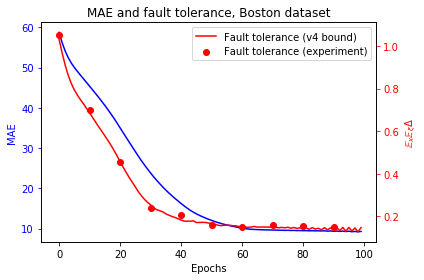

In [15]:
# show data
self = exp

fig, ax1 = plt.subplots()
ax1.set_title('MAE and fault tolerance, Boston dataset')

ax1.plot(self.losses, 'b-')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MAE', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.set_ylabel('$\mathbb{E}_x\mathbb{E}_\\xi \Delta$', color = 'r')
ax2.plot(self.mean_error_v4, label = 'Fault tolerance (v4 bound)', color = 'r')
ax2.tick_params('y', colors='r')
ax2.scatter(*zip(*self.mean_error_exp), label = 'Fault tolerance (experiment)', color = 'r')
ax2.legend()

fig.tight_layout()
fig.show()
fig.savefig('figures/training_boston_loss_error.eps', bbox_inches = 'tight')